# Keras ile Nesne Tanıma


---

![picture](https://miro.medium.com/max/652/1*uokXCDa_O7jzfbUC9qS6cg.png)

Bu kılavuz/notebook ***Keras Kütüphanesi ile Nesne Tanıma*** uygulamaları geliştirme öğrenimini kapsamaktadır. Kılavuz tamamlandığında ***Keras ile Nesne Tanıma*** algoritmaları geliştirilebilecek düzeye gelinmiş olacak. 

Bu ve bunun gibi konularla ilgili benimle iletişime geçmek isteyenler, aşağıdaki bağlantıları kullanabilirler.

- E-posta: grboguz@gmail.com
- Instagram: https://www.instagram.com/oguzhangurbzz/
- Github: https://github.com/grboguz
- Discord: https://discord.gg/YW6mdcMnFF
- Udemy: https://www.udemy.com/user/oguzhan-gurbuz/
- Linkedin: https://www.linkedin.com/in/o%C4%9Fuzhan-g%C3%BCrb%C3%BCz-4780481a6/

Not: Eğer özel yardım talebiniz varsa bu [bağlantıdan](https://www.shopier.com/grboguz) Shopier üzerindeki özel danışmanlıklarımızı inceleyebilirsiniz. 

***Bounding Box Regression*** tekniğini kullanarak nesne tanıma uygulaması geliştireceğiz.

### İçerik

  1.   Bounding Box Regression
  2.   Single Class Object Detection
  3.   Multi Class Object Detection 

### Bounding Box Regression

![picture](https://miro.medium.com/max/1276/1*HGWSXE8pFbAfB9zuCGXSQA.jpeg)

Bir görüntü sınıflandırma uygulaması aşağıdaki gibi çalışır:
- Bir görüntü seç
- Bir mimariye girdi olarak ver
- Üretilen olasılık matrisiyle etiketi belirle.

Aslında bounding box regression tekniği de buna benzer şekilde çalışır fakat bazı noktalarda farklılıklar mevcuttur. Alışılagelmiş bir regresyon modeli bize sadece sınıflandırma sonucunu verir. Sınırlandırıcı dikdörtgenler üretmez. Tipik bir regresyon modeli aşağıdaki uygulamalarda kullanılabilir:
- Ev fiyat tahmini
- Borsa tahmini
- Popülasyon artış hızı

![picture](https://www.imsl.com/sites/default/files/image/2021-06/IMSL%20What%20is%20Regression%20Model%20Blog%20Feature.png)

Tipik bir regresyon modeli üzerinde aşağıdaki değişiklikler yapılırsa, bu mimari bize sınırlayıcı noktalar da döndürür:
- Sırasıyla sol üst ve sağ alt (x, y) koordinatlarına karşılık gelen dört nöronlu tam bağlantılı(fully connected) bir katman oluşturulmalı

- Bu dört nöron katmanı [0,1] aralığında çıktılar döndürmeli. Bunun içinde sigmoid fonksiyonu uygulanmalı

- Modeli, (1) giriş görüntülerinden ve (2) görüntüdeki nesnenin sınırlayıcı kutusundan oluşan eğitim verilerinde mean-squared error (ortalama kare hatası) veya mean-absolute error (ortalama mutlak hata) gibi bir kayıp işlevi kullanarak eğitilmeli.

### Tek Sınıflı Nesne Tanıma Uygulaması (Single Class Object Detection)

Uygulamamıza ilk olarak veri kümemizi oluşturarak başlayalım. Bu bağlantıdan (https://data.caltech.edu/records/mzrjq-6wc02) veri kümemizi indirelim ve sadece tek sınıflı olacak şekilde bir alt küme (subset) oluşturalım. Alt küme oluşturmak için [videodaki](https://www.udemy.com/user/oguzhan-gurbuz/) adımları birebir takip ediniz.

![picture](https://debuggercafe.com/wp-content/uploads/2020/03/caltech101exp-min.png)

Alt kümeyi oluşturup sonra Google Drive hesabınıza yükledikten sonra kodlarımızı yazmaya başlayabiliriz !

GPU Testi

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name == "/device:GPU:0":
  print("Found GPU at: {}".format(device_name))
else:
  print("GPU device not found")

Found GPU at: /device:GPU:0


Google Drive Bağlantısı

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/gdrive/MyDrive/caltech101

/content/gdrive/MyDrive/caltech101


In [ ]:
!unzip subset_caltech.zip

Ön tanımlamaları yap.

- Görüntülerin dizini
- Etiketlerin dizini
- Eğitim parametreleri

In [ ]:
IMAGES_PATH = "/content/gdrive/MyDrive/caltech101/subset_caltech/motorbikes/images"
LABELS_PATH = "/content/gdrive/MyDrive/caltech101/subset_caltech/motorbikes/labels"
MODEL_PATH = "/content/gdrive/MyDrive/caltech101/subset_caltech/model.h5"
PLOT_PATH = "/content/gdrive/MyDrive/caltech101/subset_caltech/plot.png"

In [ ]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

Dataset İnceleme & Düzenleme

In [ ]:
import os 
#os.listdir(IMAGES_PATH)

In [ ]:
num_images = len(os.listdir(IMAGES_PATH))
num_labels = len(os.listdir(LABELS_PATH))

print("[INFO]..Images:",num_images)
print("[INFO]..Labels:",num_labels)

[INFO]..Images: 798
[INFO]..Labels: 798


In [ ]:
image_paths = os.listdir(IMAGES_PATH)
image_paths.sort()
# image_paths

In [ ]:
label_paths = os.listdir(LABELS_PATH)
label_paths.sort()
# label_paths

Görüntü ve etiketleri eşleştiren aşağıdaki gibi bir liste oluştur:
-  `[dosya, x, y, z, q]`
- `[img.jpg, 19, 141, 32, 244]`

In [ ]:
from scipy.io import loadmat

In [ ]:
motorbike = []

for i in range(0, len(label_paths)):

  image = image_paths[i]
  label = label_paths[i]

  label_path = os.path.join(LABELS_PATH, label)
  annot = loadmat(label_path)["box_coord"][0]
  #print(type(annot))
  #print(i)

  annot = annot.tolist()
  #print(type(annot))

  annot.insert(0,image)
  motorbike.append(annot)

In [ ]:
print("[INFO]\n-----------------------")
print("Num Of Item:",len(motorbike))

for i in range(0,10):
  print(motorbike[i])

[INFO]
-----------------------
Num Of Item: 798
['image_0001.jpg', 19, 141, 31, 233]
['image_0002.jpg', 15, 142, 32, 232]
['image_0003.jpg', 20, 143, 30, 234]
['image_0004.jpg', 15, 132, 30, 231]
['image_0005.jpg', 19, 145, 31, 232]
['image_0006.jpg', 20, 142, 32, 231]
['image_0007.jpg', 16, 121, 33, 230]
['image_0008.jpg', 17, 125, 31, 232]
['image_0009.jpg', 18, 133, 31, 231]
['image_0010.jpg', 18, 127, 32, 233]


Eğitim için Görüntüleri Hazırlama

In [ ]:
data = []
filenames = []
bounding_box = []

`['image_0001.jpg', 19, 141, 31, 233]`

`[filename, startY, endY, startX, endX]`

In [ ]:
import cv2

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
for info in motorbike:
  (filename, startY, endY, startX, endX) = info

  image_path = os.path.join(IMAGES_PATH, filename)
  print(image_path)

  image = cv2.imread(image_path)
  (h,w) = image.shape[:2]

  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h

  image = load_img(image_path, target_size=(224,224))
  image = img_to_array(image)

  data.append(image)
  bounding_box.append((startX, startY, endX, endY))
  filenames.append(filename)

In [ ]:
len(data)

798

In [ ]:
import numpy as np

In [ ]:
# [0,255] --> [0,1]
data = np.array(data, dtype="float32")/255
bbox = np.array(bounding_box, dtype="float32")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data.shape

(798, 224, 224, 3)

In [ ]:
# 90%(train)- 10%(test)
split = train_test_split(data, bbox, filenames, test_size=0.10, random_state=42)

`split = [ trainImages, testImages, trainBBox, testBBox, trainFilenames, testFilenames ]`

In [ ]:
(trainImages, testImages) = split[:2]
(trainBBox, testBBox) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [ ]:
# test dosyalarımı kullanmak üzere bir değişken içerisine kaydedelim.
print("[INFO]...saving testing file names")
test_paths = []

for i in range(0, len(testFilenames)):
  test_paths.append(testFilenames[i])

print("[INFO]...done")
print("[INFO]..Number of Test Images:", len(test_paths))

[INFO]...saving testing file names
[INFO]...done
[INFO]..Number of Test Images: 80


Modeli Oluşturma

Bu aşamada transfer learning tekniği kullanılacaktır. Eğer yeterli hissetmiyorsanız lütfen bu [makaleyi](https://keras.io/guides/transfer_learning/) okuyun ve [videodaki](https://www.udemy.com/user/oguzhan-gurbuz/) açıklamaları dikkatlice takip ediniz.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))
vgg.trainable = False

output = vgg.output
flatten = Flatten()(output)

bboxLayer = Dense(128, activation="relu")(flatten)
bboxLayer = Dense(64, activation="relu")(bboxLayer)
bboxLayer = Dense(32, activation="relu")(bboxLayer)
bboxLayer = Dense(4, activation="sigmoid")(bboxLayer)

model = Model(inputs=vgg.input, outputs=bboxLayer)

In [ ]:
opt = Adam(lr=INIT_LR)
model.compile(loss="mse", optimizer=opt)
model.summary()

Eğitim

In [ ]:
print("[INFO].. training progress..")
history = model.fit(trainImages,
                    trainBBox,
                    validation_data = (testImages, testBBox),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    verbose=1)

23/23 [==============================] - 4s 175ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/25
23/23 [==============================] - 4s 176ms/step - loss: 8.9144e-04 - val_loss: 0.0011
Epoch 5/25
23/23 [==============================] - 4s 173ms/step - loss: 7.7014e-04 - val_loss: 0.0010
Epoch 6/25
23/23 [==============================] - 4s 173ms/step - loss: 6.9102e-04 - val_loss: 9.4334e-04
Epoch 7/25
23/23 [==============================] - 4s 170ms/step - loss: 6.1775e-04 - val_loss: 9.1758e-04
Epoch 8/25
23/23 [==============================] - 4s 169ms/step - loss: 5.5674e-04 - val_loss: 8.7306e-04
Epoch 9/25
23/23 [==============================] - 4s 169ms/step - loss: 5.0748e-04 - val_loss: 8.3760e-04
Epoch 10/25
23/23 [==============================] - 4s 169ms/step - loss: 4.6207e-04 - val_loss: 8.1900e-04
Epoch 11/25
23/23 [==============================] - 4s 167ms/step - loss: 4.2281e-04 - val_loss: 8.0073e-04
Epoch 12/25
23/23 [==============================] - 

Visualization

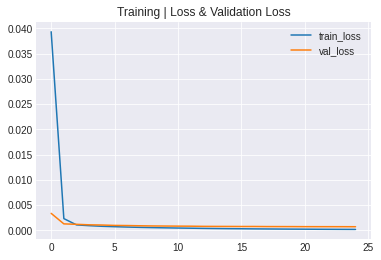

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-darkgrid")
plt.figure()

plt.plot(np.arange(0,NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,NUM_EPOCHS), history.history["val_loss"], label="val_loss")

plt.title("Training | Loss & Validation Loss")
plt.legend(loc="upper right")

In [ ]:
plt.savefig(PLOT_PATH)

<Figure size 432x288 with 0 Axes>

In [ ]:
model.save(MODEL_PATH, save_format="h5")

Prediction

In [ ]:
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

In [ ]:
model = load_model(MODEL_PATH)

# 0->80
test = os.path.join(IMAGES_PATH, test_paths[0])

# preprocess
image = load_img(test, target_size=(224,224))
image = img_to_array(image)/255.0
image = np.expand_dims(image, axis=0)

# prediction
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds

1/1 [==============================] - 0s 135ms/step


In [ ]:
import imutils

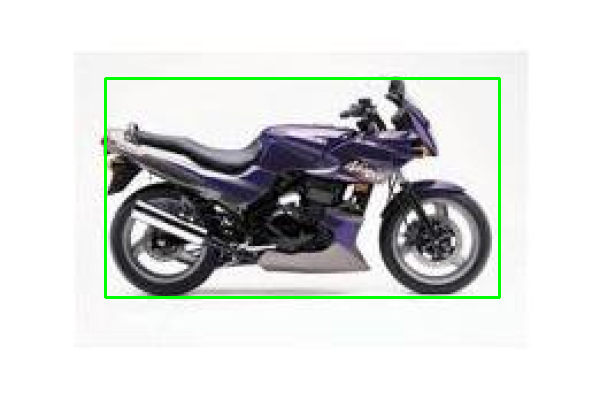

In [ ]:
image = cv2.imread(test)
image = imutils.resize(image, width=600)
(h,w) = image.shape[:2]

startX = int(startX*w)
startY = int(startY*h)
endX = int(endX*w)
endY = int(endY*h)

cv2.rectangle(image, (startX, startY), (endX, endY), (0,255,0), 2)
cv2_imshow(image)

### Çok Sınıflı Nesne Tanıma Uygulaması (Multi Class Object Detection)

Sıkıştırılımış dataset dosyasını ayrıştır.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/caltech101

/content/gdrive/MyDrive/caltech101


In [ ]:
!unzip /content/gdrive/MyDrive/caltech101/subset_caltech_multiclass.zip

Ön tanımlamaları yap.

- Görüntülerin dizini
- Etiketlerin dizini
- Eğitim parametreleri

In [ ]:
IMAGES_PATH = "/content/gdrive/MyDrive/caltech101/subset_caltech - multiclass/images"
LABELS_PATH = "/content/gdrive/MyDrive/caltech101/subset_caltech - multiclass/labels"

MODEL_PATH = "/content/gdrive/MyDrive/caltech101/subset_caltech - multiclass/model_multiclass.h5"
PLOT_PATH = "/content/gdrive/MyDrive/caltech101/subset_caltech - multiclass/plot.png"

In [ ]:
INIT_LR = 1e-4
NUM_EPOCHS = 25
BATCH_SIZE = 32

Dataset İnceleme & Düzenleme

In [ ]:
import os
# os.listdir(os.path.join(IMAGES_PATH,"airplane"))

In [ ]:
num_images_airplane = len(os.listdir(os.path.join(IMAGES_PATH,"airplane")))
num_labels_airplane = len(os.listdir(os.path.join(LABELS_PATH,"airplane")))

print("[INFO]..Images:",num_images_airplane)
print("[INFO]..Labels:",num_labels_airplane)

[INFO]..Images: 800
[INFO]..Labels: 800


In [ ]:
num_images_face = len(os.listdir(os.path.join(IMAGES_PATH,"face")))
num_labels_face = len(os.listdir(os.path.join(LABELS_PATH,"face")))

print("[INFO]..Images:",num_images_face)
print("[INFO]..Labels:",num_labels_face)

[INFO]..Images: 435
[INFO]..Labels: 435


In [ ]:
num_images_motorbike = len(os.listdir(os.path.join(IMAGES_PATH,"motorbike")))
num_labels_motorbike = len(os.listdir(os.path.join(LABELS_PATH,"motorbike")))

print("[INFO]..Images:",num_images_motorbike)
print("[INFO]..Labels:",num_labels_motorbike)

[INFO]..Images: 798
[INFO]..Labels: 798


In [ ]:
motorbike_image = os.listdir(os.path.join(IMAGES_PATH,"motorbike"))
motorbike_image.sort()
# motorbike_image

motorbike_labels = os.listdir(os.path.join(LABELS_PATH,"motorbike"))
motorbike_labels.sort()
# motorbike_labels

Görüntü ve etiketleri eşleştiren aşağıdaki gibi bir liste oluştur:
-  `[dosya, x, y, z, q, label]`
- `[img.jpg, 19, 141, 32, 244, motorbike]`

In [ ]:
from scipy.io import loadmat

In [ ]:
motorbikes = []

for i in range(0, len(motorbike_labels)):

  image = motorbike_image[i]
  label = motorbike_labels[i]

  label_path = os.path.join(LABELS_PATH,"motorbike",label)
  annot = loadmat(label_path)["box_coord"][0]
  #print(type(annot))
  print(i)

  annot = annot.tolist()
  #print(type(annot))

  annot.insert(0,image)
  annot.insert(5,"motorbike")
  motorbikes.append(annot)

In [ ]:
for i in range(0,5):
  print(motorbikes[i])

['image_0001.jpg', 19, 141, 31, 233, 'motorbike']
['image_0002.jpg', 15, 142, 32, 232, 'motorbike']
['image_0003.jpg', 20, 143, 30, 234, 'motorbike']
['image_0004.jpg', 15, 132, 30, 231, 'motorbike']
['image_0005.jpg', 19, 145, 31, 232, 'motorbike']


In [ ]:
airplane_image = os.listdir(os.path.join(IMAGES_PATH,"airplane"))
airplane_image.sort()
# motorbike_image

airplane_labels = os.listdir(os.path.join(LABELS_PATH,"airplane"))
airplane_labels.sort()
# motorbike_labels

In [ ]:
airplanes = []

for i in range(0, len(airplane_labels)):

  image = airplane_image[i]
  label = airplane_labels[i]

  label_path = os.path.join(LABELS_PATH,"airplane",label)
  annot = loadmat(label_path)["box_coord"][0]
  #print(type(annot))
  print(i)

  annot = annot.tolist()
  #print(type(annot))

  annot.insert(0,image)
  annot.insert(5,"airplane")
  airplanes.append(annot)

In [ ]:
for i in range(0,5):
  print(airplanes[i])

['image_0001.jpg', 30, 137, 49, 349, 'airplane']
['image_0002.jpg', 35, 153, 59, 342, 'airplane']
['image_0003.jpg', 36, 135, 47, 331, 'airplane']
['image_0004.jpg', 24, 141, 47, 342, 'airplane']
['image_0005.jpg', 18, 146, 48, 339, 'airplane']


In [ ]:
face_image = os.listdir(os.path.join(IMAGES_PATH,"face"))
face_image.sort()
# face_image

face_labels = os.listdir(os.path.join(LABELS_PATH,"face"))
face_labels.sort()
# face_labels

In [ ]:
faces = []

for i in range(0, len(face_labels)):

  image = face_image[i]
  label = face_labels[i]

  label_path = os.path.join(LABELS_PATH,"face",label)
  annot = loadmat(label_path)["box_coord"][0]
  #print(type(annot))
  print(i)

  annot = annot.tolist()
  #print(type(annot))

  annot.insert(0,image)
  annot.insert(5,"face")
  faces.append(annot)

In [ ]:
for i in range(0,5):
  print(faces[i])

['image_0001.jpg', 15, 300, 251, 444, 'face']
['image_0002.jpg', 31, 310, 106, 296, 'face']
['image_0003.jpg', 17, 279, 207, 385, 'face']
['image_0004.jpg', 55, 328, 102, 303, 'face']
['image_0005.jpg', 30, 312, 246, 446, 'face']


In [ ]:
all_data=[airplanes, motorbikes, faces]

In [ ]:
all_data[0][:2]

[['image_0001.jpg', 30, 137, 49, 349, 'airplane'],
 ['image_0002.jpg', 35, 153, 59, 342, 'airplane']]

In [ ]:
all_data[1][:2]

[['image_0001.jpg', 19, 141, 31, 233, 'motorbike'],
 ['image_0002.jpg', 15, 142, 32, 232, 'motorbike']]

In [ ]:
all_data[2][:2]

[['image_0001.jpg', 15, 300, 251, 444, 'face'],
 ['image_0002.jpg', 31, 310, 106, 296, 'face']]

In [ ]:
data = []
labels = []
bboxes = []
imagePaths = []

Eğitim için Görüntüleri Hazırlama

In [ ]:
import os
import cv2
import numpy as np

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
i = 0
for item in all_data:
  for info in item:
    i = i+1
    (filename, startY, endY, startX, endX, label) = info

    image_path = os.path.join(IMAGES_PATH,label,filename)
    print(i)

    image = cv2.imread(image_path)
    (h,w) = image.shape[:2]

    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    image = load_img(image_path, target_size=(224,224))
    image = img_to_array(image)

    data.append(image)
    labels.append(label)
    bboxes.append((startX, startY, endX, endY))
    imagePaths.append(filename)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
len(labels)

2033

In [ ]:
# [0,255] --> [0,1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

One-Hot Encoding

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

`labels = motorbike, face, airplane`

`[1,0,0]`

`[0,1,0]`

`[0,0,1]`

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

if len(lb.classes_) == 2:
	labels = to_categorical(labels)

In [ ]:
data.shape

(2033, 224, 224, 3)

In [ ]:
# 80%(train)- 20%(test)
split = train_test_split(data, labels, bboxes, imagePaths, test_size=0.20, random_state=42)

In [ ]:
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testFilenames) = split[6:]

In [ ]:
test_paths = []

for i in range(0,len(testFilenames)):
  test_paths.append(testFilenames[i])

Modeli Oluşturma

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)

bboxLayer = Dense(128, activation="relu")(flatten)
bboxLayer = Dense(64, activation="relu")(bboxLayer)
bboxLayer = Dense(32, activation="relu")(bboxLayer)
bboxLayer = Dense(4, activation="sigmoid",name="bounding_box")(bboxLayer)

classLayer = Dense(512, activation="relu")(flatten)
classLayer = Dropout(0.5)(classLayer)
classLayer = Dense(512, activation="relu")(classLayer)
classLayer = Dropout(0.5)(classLayer)
classLayer = Dense(len(lb.classes_), activation="softmax", name="class_label")(classLayer)

model = Model(inputs=vgg.input, outputs=(bboxLayer, classLayer))

In [ ]:
losses = {"class_label": "categorical_crossentropy",
          "bounding_box": "mean_squared_error"}

lossWeights = {"class_label": 1.0, 
               "bounding_box": 1.0}

opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
model.summary()

Eğitim

In [ ]:
trainTargets = {"class_label": trainLabels,
                "bounding_box": trainBBoxes}


testTargets = {"class_label": testLabels,
               "bounding_box": testBBoxes}

In [ ]:
print("[INFO].. training progress..")
history = model.fit(trainImages, 
                    trainTargets,
                    validation_data=(testImages, testTargets),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    verbose=1)

[INFO].. training progress..
Epoch 1/25
51/51 [==============================] - 15s 297ms/step - loss: 0.1899 - bounding_box_loss: 0.0060 - class_label_loss: 0.1839 - bounding_box_accuracy: 0.5843 - class_label_accuracy: 0.9219 - val_loss: 0.0035 - val_bounding_box_loss: 0.0017 - val_class_label_loss: 0.0018 - val_bounding_box_accuracy: 0.8649 - val_class_label_accuracy: 1.0000
Epoch 2/25
51/51 [==============================] - 10s 203ms/step - loss: 0.0180 - bounding_box_loss: 0.0012 - class_label_loss: 0.0168 - bounding_box_accuracy: 0.8801 - class_label_accuracy: 0.9963 - val_loss: 0.0016 - val_bounding_box_loss: 0.0010 - val_class_label_loss: 5.5372e-04 - val_bounding_box_accuracy: 0.8649 - val_class_label_accuracy: 1.0000
Epoch 3/25
51/51 [==============================] - 10s 205ms/step - loss: 0.0090 - bounding_box_loss: 8.5676e-04 - class_label_loss: 0.0082 - bounding_box_accuracy: 0.8868 - class_label_accuracy: 0.9982 - val_loss: 0.0012 - val_bounding_box_loss: 8.6994e-04 - 

In [ ]:
import pickle

In [ ]:
model.save(MODEL_PATH,save_format="h5")
BASE = "/content/gdrive/MyDrive/caltech101/subset_caltech - multiclass"

LB_PATH = os.path.join(BASE, "lb.pickle")
f = open(LB_PATH,"wb")
f.write(pickle.dumps(lb))
f.close()

Prediction

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.models import load_model

In [ ]:
model = load_model(MODEL_PATH)
lb = pickle.loads(open(LB_PATH,"rb").read())

In [ ]:
# preprocess
test = "/content/gdrive/MyDrive/caltech101/subset_caltech - multiclass/images/face/image_0002.jpg"
test1 = "/content/gdrive/MyDrive/caltech101/subset_caltech - multiclass/images/airplane/image_0006.jpg"
test2 = "/content/gdrive/MyDrive/caltech101/subset_caltech - multiclass/images/motorbike/image_0005.jpg"

image = load_img(test2, target_size=(224,224))
image = img_to_array(image)/255.0
image = np.expand_dims(image, axis=0)

In [ ]:
# prediction
preds = model.predict(image)
preds

1/1 [==============================] - 0s 19ms/step


[array([[0.11862583, 0.11134207, 0.882199  , 0.87875926]], dtype=float32),
 array([[4.0326899e-08, 5.0525724e-08, 9.9999988e-01]], dtype=float32)]

In [ ]:
(startX, startY, endX, endY) = preds[0][0]

In [ ]:
predicted_labels = {0:"airplane",
                    1:"face",
                    2:"motorbike"}

In [ ]:
preds[1]

array([[4.0326899e-08, 5.0525724e-08, 9.9999988e-01]], dtype=float32)

In [ ]:
import cv2
import imutils
import numpy as np

In [ ]:
predicted_label = preds[1]
predicted_label = np.argmax(predicted_label)
predicted_label = predicted_labels[predicted_label]
print(predicted_label)

motorbike


In [ ]:
image = cv2.imread(test2)
image = imutils.resize(image, width=600)
(h,w) = image.shape[:2]

startX = int(startX*w) 
startY = int(startY*h) 
endX = int(endX*w)  
endY = int(endY*h) 

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX

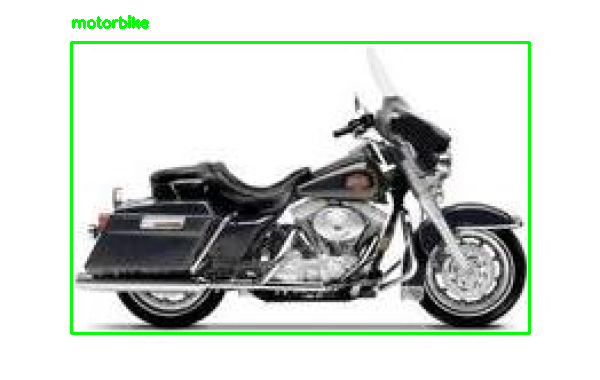

In [ ]:
cv2.putText(image, predicted_label, (startX,startY-15), font, 0.5, (0,255,0), 2)
cv2.rectangle(image, (startX,startY), (endX,endY), (0,255,0), 2)

cv2_imshow(image)